In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/rul-dataset/RUL_FD002.txt
/kaggle/input/rul-dataset/test_FD003.txt
/kaggle/input/rul-dataset/readme.txt
/kaggle/input/rul-dataset/train_FD003.txt
/kaggle/input/rul-dataset/test_FD004.txt
/kaggle/input/rul-dataset/train_FD004.txt
/kaggle/input/rul-dataset/test_FD002.txt
/kaggle/input/rul-dataset/train_FD001.txt
/kaggle/input/rul-dataset/train_FD002.txt
/kaggle/input/rul-dataset/RUL_FD001.txt
/kaggle/input/rul-dataset/RUL_FD004.txt
/kaggle/input/rul-dataset/RUL_FD003.txt
/kaggle/input/rul-dataset/test_FD001.txt


In [2]:
import pandas as pd
import numpy as np
import gym
from gym import spaces
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import random  # Assurez-vous que cette ligne est incluse




# ====================================
# STEP 1: Load and preprocess the data
# ====================================
# Load training and test data
train_data = pd.read_csv('/kaggle/input/rul-dataset/train_FD002.txt', sep=" ", header=None).dropna(axis=1)
test_data = pd.read_csv('/kaggle/input/rul-dataset/test_FD002.txt', sep=" ", header=None).dropna(axis=1)
rul_data = pd.read_csv('/kaggle/input/rul-dataset/RUL_FD002.txt', header=None)

# Define column names
columns = ['Unit', 'Cycle', 'Operational_Setting_1', 'Operational_Setting_2', 'Operational_Setting_3'] + \
          [f'Sensor_{i}' for i in range(1, 22)]
train_data.columns = columns
test_data.columns = columns
rul_data.columns = ['RUL']
rul_data['Unit'] = rul_data.index + 1  # On commence à 1 pour correspondre aux unités de test1
# Normalize the data
scaler = MinMaxScaler()
train_data[columns[2:]] = scaler.fit_transform(train_data[columns[2:]])
train_data['RUL'] = train_data.groupby('Unit')['Cycle'].transform(max) - train_data['Cycle']
test_data[columns[2:]] = scaler.transform(test_data[columns[2:]])
test_data = pd.merge(test_data, rul_data, on="Unit", how="left")

/tmp/ipykernel_24/2848165693.py:34: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  train_data['RUL'] = train_data.groupby('Unit')['Cycle'].transform(max) - train_data['Cycle']


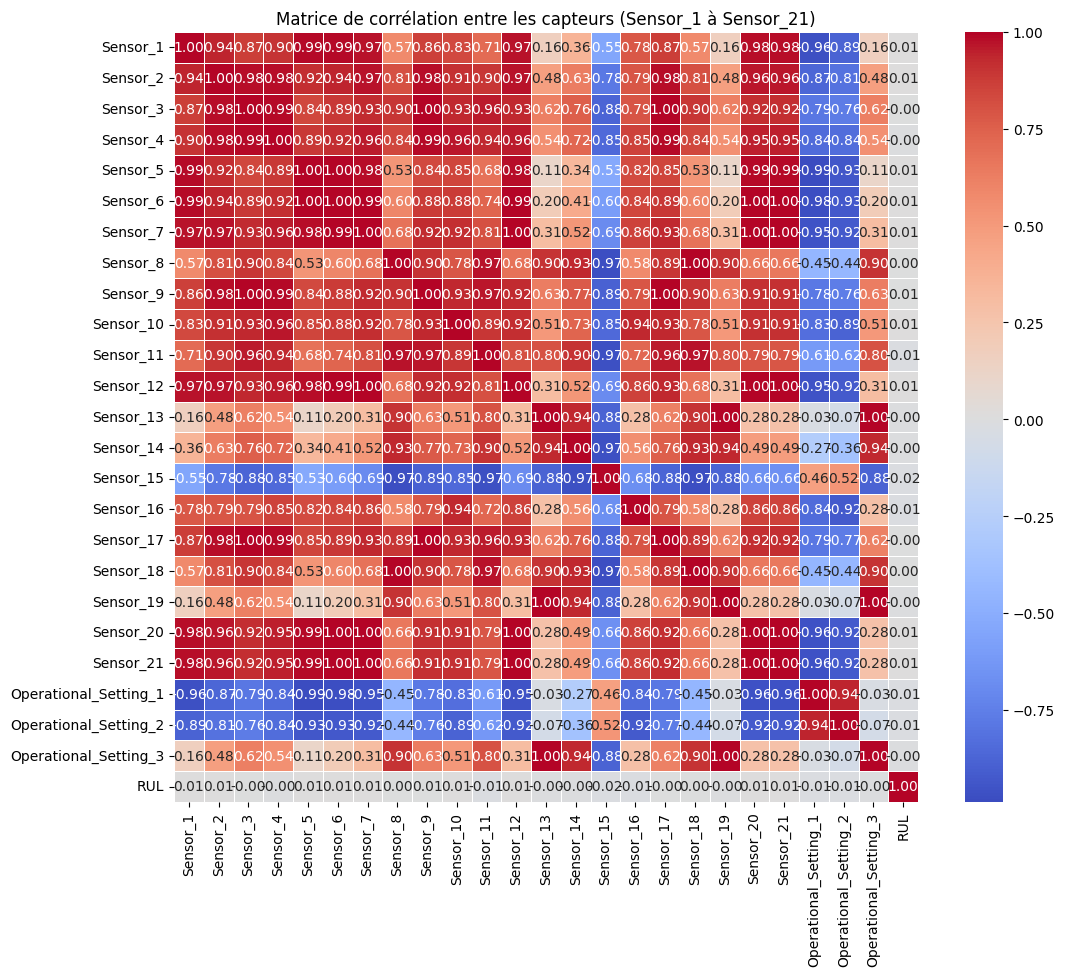

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
# Sélectionner uniquement les colonnes des capteurs de Sensor_1 à Sensor_21
sensor_columns = [f'Sensor_{i}' for i in range(1, 22)]
sensor_columns.append('Operational_Setting_1')
sensor_columns.append('Operational_Setting_2')
sensor_columns.append('Operational_Setting_3')
sensor_columns.append('RUL')
# Crée une liste ['Sensor_1', 'Sensor_2', ..., 'Sensor_21']
sensor_data = test_data[sensor_columns]
# Calculer la matrice de corrélation entre les capteurs
corr = sensor_data.corr()
# Afficher la heatmap
plt.figure(figsize=(12, 10))  # Ajustez la taille du graphique si nécessaire
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Matrice de corrélation entre les capteurs (Sensor_1 à Sensor_21)")
plt.show()


In [ ]:
# Charger les nouvelles données
new_data = pd.read_csv('/kaggle/input/rul-dataset/test_FD003.txt', sep=" ", header=None).dropna(axis=1)

# Ajouter les noms de colonnes
new_data.columns = ['Unit', 'Cycle', 'Operational_Setting_1', 'Operational_Setting_2', 'Operational_Setting_3'] + \
                   [f'Sensor_{i}' for i in range(1, 22)]

# Normaliser les nouvelles données avec le scaler existant
new_data[columns[2:]] = scaler.transform(new_data[columns[2:]])


In [ ]:
new_test_data= pd.merge(new_data, rul_data, on="Unit", how="left")

In [ ]:
# Importation des bibliothèques nécessaires
import os
import random
import numpy as np
from collections import deque
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Lambda, Add
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K
import pandas as pd
import gym
import pylab

# 1. Définir l'environnement personnalisé basé sur les données de train
class CustomEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, data, critical_threshold):
        # Charger les données directement depuis la variable
        self.data = data
        self.num_states = self.data.shape[1] - 1  # Supposons que la dernière colonne est la récompense
        self.action_space = gym.spaces.Discrete(2)  # 2 actions : maintenir ou remplacer
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(self.num_states,))
        self.current_index = 0  # Position actuelle dans les données
        self.critical_threshold = critical_threshold  # Le seuil critique de RUL

    def step(self, action):
        # Récupérer l'état actuel
        state = self.data.iloc[self.current_index, :-1].values
        RUL = self.data.iloc[self.current_index, -1]  # La dernière colonne représente le RUL
        
        reward = 0
        
        if action == 1:  # Action de maintenance
            if RUL < self.critical_threshold:  # Si le RUL est en dessous du seuil critique
                reward = 10  # Récompense positive pour une maintenance préventive efficace
            else:  # Si le RUL est supérieur au seuil
                reward = -5  # Pénalité pour une maintenance inutile

        elif action == 0:  # Action de non-maintenance
            if RUL < self.critical_threshold:  # Si le RUL est en dessous du seuil critique
                reward = -10  # Forte pénalité pour ne pas avoir effectué de maintenance à temps
            else:  # Si le RUL est supérieur au seuil
                reward = 0  # Pas de pénalité ni de récompense

        # Passer au cycle suivant
        self.current_index += 1
        done = self.current_index >= len(self.data)  # Terminer si les données sont épuisées

        # Nouvel état
        next_state = self.data.iloc[self.current_index, :-1].values if not done else np.zeros(self.num_states)
        return next_state, reward, done, {}

    def reset(self):
        self.current_index = 0
        return self.data.iloc[self.current_index, :-1].values


# 2. Implémenter l'agent Double Deep Q-Learning (D3QN) avec PER
class SumTree:
    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype=object)
        self.data_pointer = 0

    def add(self, priority, data):
        tree_index = self.data_pointer + self.capacity - 1
        self.data[self.data_pointer] = data
        self.update(tree_index, priority)

        self.data_pointer += 1
        if self.data_pointer >= self.capacity:
            self.data_pointer = 0

    def update(self, tree_index, priority):
        change = priority - self.tree[tree_index]
        self.tree[tree_index] = priority
        while tree_index != 0:
            tree_index = (tree_index - 1) // 2
            self.tree[tree_index] += change

    def get_leaf(self, v):
        parent_index = 0
        while True:
            left_child_index = 2 * parent_index + 1
            right_child_index = left_child_index + 1
            if left_child_index >= len(self.tree):
                leaf_index = parent_index
                break
            else:
                if v <= self.tree[left_child_index]:
                    parent_index = left_child_index
                else:
                    v -= self.tree[left_child_index]
                    parent_index = right_child_index

        data_index = leaf_index - self.capacity + 1
        return leaf_index, self.tree[leaf_index], self.data[data_index]

    @property
    def total_priority(self):
        return self.tree[0]

class Memory:
    def __init__(self, capacity):
        self.tree = SumTree(capacity)

    def store(self, experience):
        max_priority = np.max(self.tree.tree[-self.tree.capacity:])
        if max_priority == 0:
            max_priority = 1.0
        self.tree.add(max_priority, experience)

    def sample(self, n):
        minibatch = []
        idxs = []
        segment = self.tree.total_priority / n

        for i in range(n):
            a = segment * i
            b = segment * (i + 1)
            s = random.uniform(a, b)
            idx, _, data = self.tree.get_leaf(s)
            idxs.append(idx)
            minibatch.append(data)

        return idxs, minibatch

    def batch_update(self, idxs, abs_errors):
        abs_errors = np.minimum(abs_errors + 0.01, 1.0)
        for idx, p in zip(idxs, abs_errors):
            self.tree.update(idx, p)

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = Memory(2000)
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.batch_size = 32
        self.model = self.build_model()
        self.target_model = self.build_model()

    def build_model(self):
        inputs = Input(shape=(self.state_size,))
        layer = Dense(24, activation='relu')(inputs)
        layer = Dense(24, activation='relu')(layer)
        outputs = Dense(self.action_size, activation='linear')(layer)
        model = Model(inputs, outputs)
        model.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse')
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, next_state, done):
        self.memory.store((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def replay(self):
        if len(self.memory.tree.data) < self.batch_size:
            return

        idxs, minibatch = self.memory.sample(self.batch_size)
        states, targets = [], []
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.target_model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            states.append(state[0])
            targets.append(target_f[0])

        self.model.fit(np.array(states), np.array(targets), epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

rul_per_engine = train_data.groupby('Unit')['RUL'].max()
critical_threshold = rul_per_engine.mean() - rul_per_engine.std()
# 3. Entraîner l'agent avec les données
# 3. Entraîner l'agent avec les données, calculer les métriques et visualiser
if __name__ == "__main__":
    env = CustomEnv(train_data, critical_threshold)
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DQNAgent(state_size, action_size)

    # Initialiser les métriques
    rewards_history = []  # Historique des récompenses cumulées
    critical_error_count = []  # Historique des erreurs critiques
    total_costs = []  # Historique des coûts totaux

    episodes = 300
    for e in range(episodes):
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        episode_reward = 0  # Récompense cumulative pour cet épisode
        episode_critical_errors = 0  # Nombre d'erreurs critiques pour cet épisode
        episode_cost = 0  # Coût total pour cet épisode

        for time in range(100):
            # Agent choisit une action
            action = agent.act(state)
            
            # Environnement retourne les résultats de l'action
            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])
            
            # Ajouter à la mémoire et mettre à jour l'agent
            agent.remember(state, action, reward, next_state, done)

            # Mettre à jour les métriques
            episode_reward += reward
            if action == 0 and reward == -10:  # Erreur critique
                episode_critical_errors += 1
            elif action == 1 and reward == -5:  # Maintenance inutile
                episode_cost += 5

            # Afficher les informations de l'étape
            print(f"Épisode: {e}, Étape: {time}, Action: {action}, Récompense: {reward}")
            
            # Passer à l'état suivant
            state = next_state
            if done:
                break
        
        # Mettre à jour le modèle cible à la fin de l'épisode
        agent.update_target_model()

        # Ajouter les métriques de l'épisode aux historiques
        rewards_history.append(episode_reward)
        critical_error_count.append(episode_critical_errors)
        total_costs.append(episode_cost)

        # Afficher les informations de l'épisode
        print(f"Episode terminé: {e}/{episodes}, Récompense cumulée: {episode_reward}, "
              f"Erreurs critiques: {episode_critical_errors}, Coût total: {episode_cost}, "
              f"Epsilon: {agent.epsilon:.2f}")
        
        # Faire un replay pour entraîner le modèle
        agent.replay()

    # Visualisation des métriques
    episodes_range = range(episodes)

    # Récompense cumulée
    pylab.figure(1)
    pylab.plot(episodes_range, rewards_history, label="Récompense Cumulée")
    pylab.xlabel("Épisodes")
    pylab.ylabel("Récompense")
    pylab.title("Récompense Cumulée par Épisode")
    pylab.legend()
    pylab.savefig("reward_per_episode.png")

    # Erreurs critiques
    pylab.figure(2)
    pylab.plot(episodes_range, critical_error_count, label="Erreurs Critiques", color="red")
    pylab.xlabel("Épisodes")
    pylab.ylabel("Nombre d'Erreurs")
    pylab.title("Nombre d'Erreurs Critiques par Épisode")
    pylab.legend()
    pylab.savefig("critical_errors_per_episode.png")

    # Coût total
    pylab.figure(3)
    pylab.plot(episodes_range, total_costs, label="Coût Total", color="green")
    pylab.xlabel("Épisodes")
    pylab.ylabel("Coût")
    pylab.title("Coût Total par Épisode")
    pylab.legend()
    pylab.savefig("total_cost_per_episode.png")

    pylab.show()



Épisode: 0, Étape: 0, Action: 0, Récompense: -10
Épisode: 0, Étape: 1, Action: 1, Récompense: 10
Épisode: 0, Étape: 2, Action: 0, Récompense: -10
Épisode: 0, Étape: 3, Action: 0, Récompense: -10
Épisode: 0, Étape: 4, Action: 0, Récompense: -10
Épisode: 0, Étape: 5, Action: 1, Récompense: 10
Épisode: 0, Étape: 6, Action: 0, Récompense: -10
Épisode: 0, Étape: 7, Action: 0, Récompense: -10
Épisode: 0, Étape: 8, Action: 0, Récompense: -10
Épisode: 0, Étape: 9, Action: 0, Récompense: -10
Épisode: 0, Étape: 10, Action: 0, Récompense: -10
Épisode: 0, Étape: 11, Action: 1, Récompense: 10
Épisode: 0, Étape: 12, Action: 0, Récompense: -10
Épisode: 0, Étape: 13, Action: 0, Récompense: -10
Épisode: 0, Étape: 14, Action: 0, Récompense: -10
Épisode: 0, Étape: 15, Action: 0, Récompense: -10
Épisode: 0, Étape: 16, Action: 1, Récompense: 10
Épisode: 0, Étape: 17, Action: 0, Récompense: -10
Épisode: 0, Étape: 18, Action: 0, Récompense: -10
Épisode: 0, Étape: 19, Action: 0, Récompense: -10
Épisode: 0, Ét

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Épisode: 225, Étape: 33, Action: 1, Récompense: 10
Épisode: 225, Étape: 34, Action: 0, Récompense: -10
Épisode: 225, Étape: 35, Action: 1, Récompense: 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Épisode: 225, Étape: 36, Action: 1, Récompense: 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Épisode: 225, Étape: 37, Action: 1, Récompense: 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Épisode: 225, Étape: 38, Action: 1, Récompense: 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Épisode: 225, Étape: 39, Action: 1, Récompense: 10
Épisode: 225, Étape: 40, Action: 0, Récompense: -10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Épisode: 225, Étape: 41, Action: 1, Récompense: 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Épisode: 225, Étape: 42, Action: 1, Récompense: 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Épisode: 225, Étape: 43, Action: 1, Récompense: 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Épisode: 225, Étape: 44, Action: 1, Récompense: 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Épisod

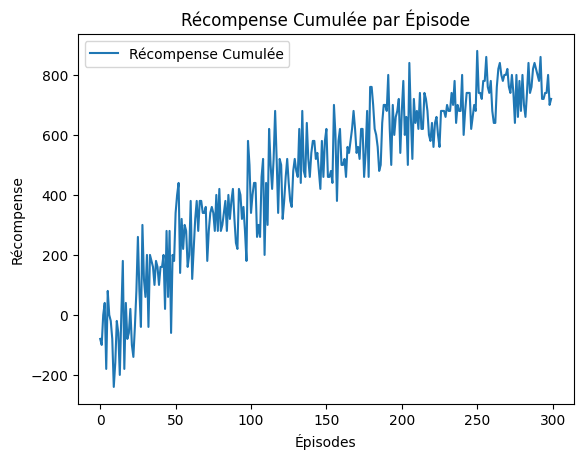

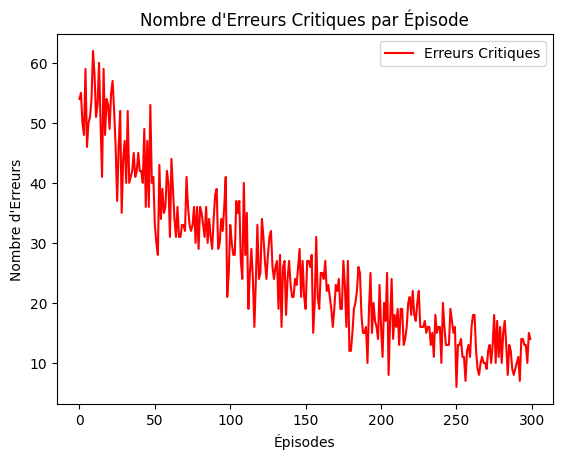

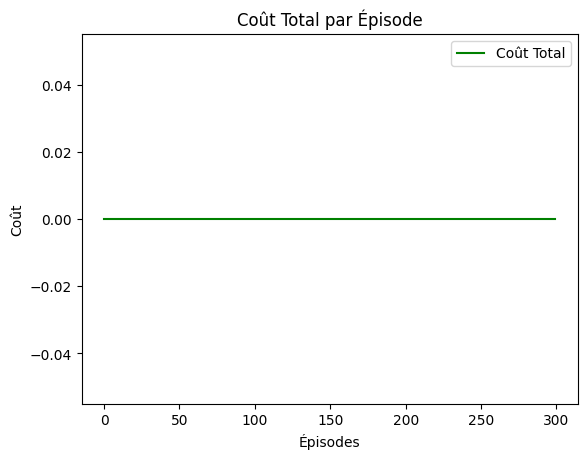

In [6]:
pylab.figure(1)
pylab.plot(episodes_range, rewards_history, label="Récompense Cumulée")
pylab.xlabel("Épisodes")
pylab.ylabel("Récompense")
pylab.title("Récompense Cumulée par Épisode")
pylab.legend()
pylab.savefig("reward_per_episode.png")

# Erreurs critiques
pylab.figure(2)
pylab.plot(episodes_range, critical_error_count, label="Erreurs Critiques", color="red")
pylab.xlabel("Épisodes")
pylab.ylabel("Nombre d'Erreurs")
pylab.title("Nombre d'Erreurs Critiques par Épisode")
pylab.legend()
pylab.savefig("critical_errors_per_episode.png")

pylab.show()
